# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image
import torch
import torch.optim as optim
from torchvision import models, transforms

%matplotlib inline
%config InlineBackend.format_figure = 'retina'

In [2]:
%reload_ext autoreload
%autoreload 2

# Model Preps

In [3]:
PATH = Path('../data/style_transfer_imgs/')
!ls {PATH}

ben_passmore.jpg  janelle.png	octavia.jpg	      sotomayor.jpg
delaunay.jpg	  kahlo.jpg	octopus.jpg	      space_needle.jpg
hockney.jpg	  magritte.jpg	professional_pic.jpg


In [4]:
vgg = models.vgg19(pretrained=True)
vgg

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/jupyter/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:10<00:00, 52501194.48it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

We only need the convolution base and not the classifier. So will discard the classifier part.

In [5]:
vgg = vgg.features
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [6]:
# Freeze all layers because we do not want to train it
for param in vgg.parameters():
    param.requires_grad = False
print(f'Trainable parameters : '
      f'{len([param for param in vgg.parameters() if param.requires_grad])}')

Trainable parameters : 0


In [7]:
# Means and stds using for Imagenet to normalize images
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

In [8]:
def load_img(fname, shape=None, max_size=400, means=None, stds=None):
    '''Load an Image and transform it to tensor'''
    # Read the image and convert it to RGB
    img = Image.open(fname).convert('RGB')
    
    if shape:
        size = shape
    elif max(img.size) > max_size:
        size = max_size
    else:
        size = max(img.size)
    
    # Resize, convert to tensor, and normalize to imagenet
    img_tfms = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ])
    
    img = img_tfms(img)[None]   # Add batch dimension
    
    return img

In [9]:
content_img = load_img(PATH / 'octopus.jpg', max_size=400, means=means, stds=stds)

# Will make the style image of the same size of the content image
style_img = load_img(PATH / 'hockney.jpg', shape=content_img.size()[-2:], means=means, stds=stds)

print(f'Content image size : {content_img.size()}')
print(f'Style image size : {style_img.size()}')

Content image size : torch.Size([1, 3, 400, 592])
Style image size : torch.Size([1, 3, 400, 592])


In [10]:
def convert_images(images, mean, std):
    '''Convert image from a torch tensor.'''
    img = images.to('cpu').clone().detach()
    img = img.numpy()
    img = img.transpose([1, 2, 0])
    img = img * std + mean
    img = np.clip(img, 0, 1)
    
    return img

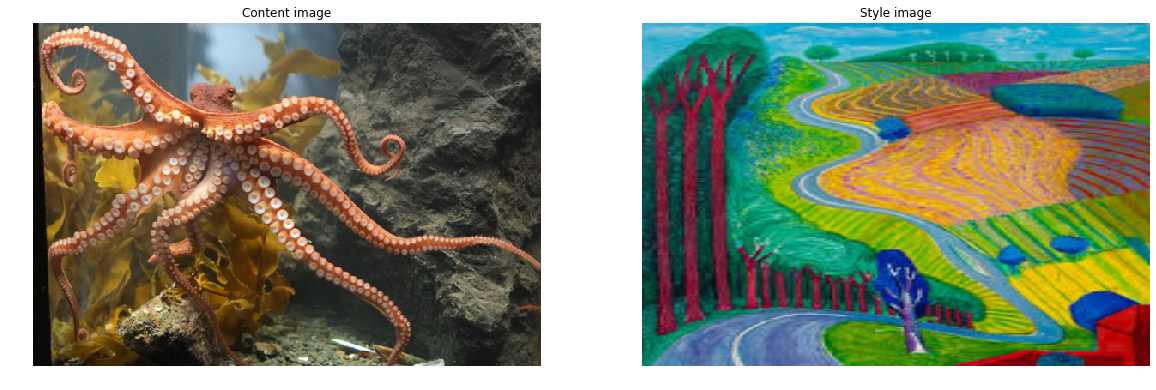

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(convert_images(content_img[0], means, stds))
axes[0].set_title('Content image')
axes[0].set_axis_off()
axes[1].imshow(convert_images(style_img[0], means, stds))
axes[1].set_title('Style image')
axes[1].set_axis_off()

We will use the first convolution layer in each convolution block for the style representation. We have 5 convolution blocks, so we have to get the index for each the first layer from each of the 5 conv blocks. `conv4_2` will be the layer that is used for the content representation. 

In [12]:
# conv4_2 for content representation
def get_features(image, model, layers=None):
    if not layers:
        layers = {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1',
                  '19': 'conv4_1', '21': 'conv4_2', '28': 'conv5_1'}
    
    features, x = {}, image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    
    return features

model._modules is an ordered dictionary that contains all the modules of the model. So we can run each one separately based on it weights.

Gram matrix in this context measures the correlation between feature maps. So if we have layer output that is C x H x W, the Gram matrix will be H x W where diagonal elements measures how active each feature map is. But the off-diagonal elements measures the correlation between other feature maps. 

In [13]:
# Gram matrix is basically the dot product between the matrix and its trasnpose
def gram_matrix(tensor):
    '''Compute the Gram matrix of a given matrix.'''
    n, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    gram = tensor.matmul(tensor.t())
    
    return gram

We have two kinds of weight that we will be using when training to get the target (generated) image having both the style from the style image and the content from the content image.
- Weights for style layers. Each layer will be waited with $w_i$ which is between $[0, 1]$. Most commonly earlier layers will have larger weights that later layers to get larger style artifacts. However, we can change those weights to get the image we want.
- Weights for the style and content losses. $\alpha$ will be the weight for the content loss and $\beta$ will be the weight for the style loss. It is recommended to have $\alpha = 1$ and change $\beta$. The larger the $\beta$ the more stylish the target image will be and less content. Each image may require different values for $\alpha$ and $\beta$.

In [42]:
style_weights = {'conv1_1': 1, 'conv2_1': .8, 'conv3_1': .2,
                 'conv4_1': .2, 'conv5_1': .2}
alpha = 1   # content loss weight
beta = 1e6  # style loss weight

# Training

In [43]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Device used for training : {device}')

Device used for training : cuda:0


In [44]:
# Load content and style image
content_img = load_img(PATH / 'my_pic.jpg', max_size=400, means=means, stds=stds)
style_img = load_img(PATH / 'hockney.jpg', shape=content_img.size()[-2:],
                     means=means, stds=stds)
content_img = content_img.to(device)
style_img = style_img.to(device)
vgg = vgg.to(device)

In [45]:
# Get content and style features
content_features = get_features(content_img, vgg, layers={'21': 'conv4_2'})
style_features = get_features(style_img, vgg)

# Compute Gram matrix for style features
style_grams = {layer: gram_matrix(style_features[layer])
               for layer in style_features}

# Create target image using content image and random noise
target_img = content_img.clone()#.normal_()
# Set grads to True and move it to device
target_img = target_img.requires_grad_(True).to(device)

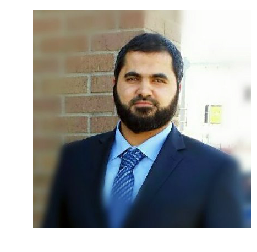

In [46]:
# Show initialized target image
plt.imshow(convert_images(target_img[0], means, stds))
plt.axis('off');

Style transfer started ...
Total loss : 32483970.00


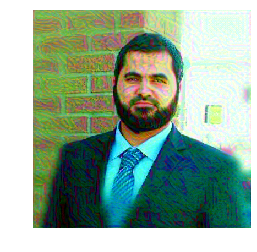

Total loss : 12202450.00


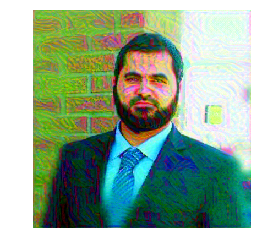

Total loss : 6921394.50


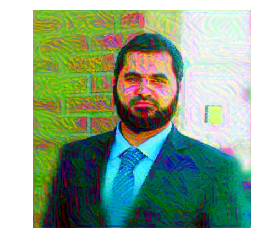

Total loss : 4636750.00


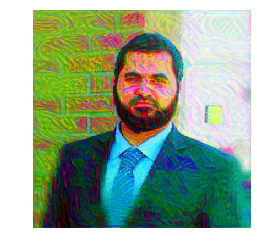

Total loss : 3224367.00


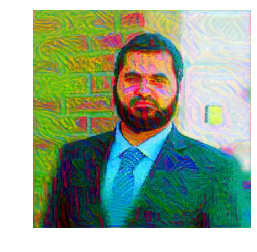

Total loss : 2270246.25


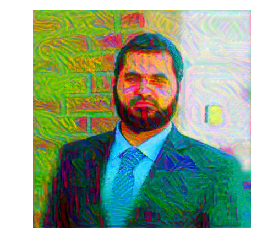

Total loss : 1617740.00


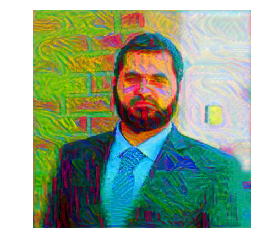

Total loss : 1170832.25


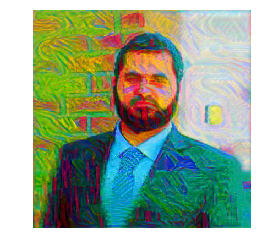

Total loss : 864246.62


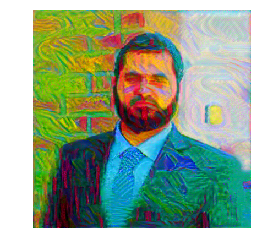

Total loss : 651470.38


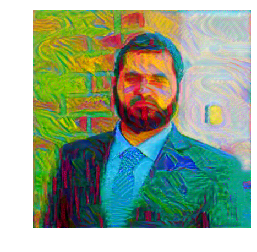

In [47]:
# Training
STEPS = 5000
optimizer = optim.Adam([target_img], lr=3e-3)

print(f'Style transfer started ...')
for step in range(STEPS):
    # Get features from target image
    target_features = get_features(target_img, vgg)
    
    # Compute MSE between content_img and target_img
    content_loss = ((content_features['conv4_2'] - target_features['conv4_2']) ** 2).mean()
    
    # Iterate over all layers in style features
    style_loss = 0
    for layer in style_weights:
        # Compute style rep and gram matrix for target
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, c, h, w = target_feature.size()
        
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * ((style_gram - target_gram) ** 2).mean()
        
        # Normalize layer loss and add it to total style loss
        style_loss += layer_style_loss / (c * h * w)
    
    # Compute total loss
    total_loss = alpha * content_loss + beta * style_loss
    
    # Back prop
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # Show target image every 100 steps
    if (step + 1) % 500 == 0:
        print(f'Total loss : {total_loss.item():.2f}')
        plt.imshow(convert_images(target_img[0], means, stds))
        plt.axis('off')
        plt.show()

In [50]:
plt.imsave('my_pic_style_transfer.jpg', convert_images(target_img[0], means, stds))